In this notebook, the key figures included in the results section are generated. To create these figures, data is needed. In the file xxxx, the data is created. First the necessary libraries are imported

In [1]:
# Import necessary libraries
import pandas as pd 
from ema_workbench.analysis import prim
import matplotlib.pyplot as plt
from SALib.analyze import sobol
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.analysis import dimensional_stacking

# Choosing the problem formulation id
dike_model, planning_steps = get_model_for_problem_formulation(2)

# Ignore warnings 
import warnings
warnings.filterwarnings("ignore")

# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)

## Open Exploration

### 'do-nothing' policy
In this section of the notebook, the various plots for the open exploration are created. The open exploration starts with looking at the results of a 'do nothing' policy run, this run will be used to generate scenarios which are used during the directed search. Next, subspace partitioning (PRIM, DS) is applied. Finally, a (global) sensitivity analysis (GSA) is performed using sobol indices. 

# Exploration of the zero-policy run
Firstly, the model has been run using 100 000 scenarios (using LHS) and a 'do nothing' policy. A 'do nothing' policy means that no actions are taken, all model levers have value 0. This answers the question: 'what are the consequences of not taking actions?'

In [2]:
# Load 'do nothing' policy data from the results folder
zero_policy_experiments = pd.read_csv("results/scenario_space_100000_experiments_2025-06-11_21-41.csv")
zero_policy_outcomes = pd.read_csv("results/scenario_space_100000_outcomes_2025-06-11_21-41.csv")

In [3]:
zero_policy_outcomes.head()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,1.121143e+09,0,0.0,0.0,2.001277
1,1.040173e+09,0,0.0,0.0,1.961085
2,3.219446e+09,0,0.0,0.0,3.550581
3,1.400912e+09,0,0.0,0.0,2.822709
4,3.193453e+08,0,0.0,0.0,0.519092


##### Missing part here, ideally @Pien gooi jij hier de resultaten van de zero_policy experiment


### PRIM
In this section, the Patient Rule Induction Method (PRIM) is applied to analyze the results of a run with 600 scenarios and 400 policies. This data has been produced using latin hypercube sampling (LHS) in both the uncertainty and lever space. The goal is to identify the key uncertainties and policy levers that influence the outcomes of interest.

The analysis focuses on two key questions:
1) Unfavorable outcomes: What values of which uncertainties lead to outcomes with a high number of deaths and damages?
    
    - The threshold for unfavourable outcomes is set at the 40th percentile (0.4 quantile) for both the number of deaths and annual damages. Ideally a higher threshold would have been chosen, but the PRIM algorithm did not work for higher thresholds. 
2) Favorable outcomes: What values of which policy levers lead to outcomes with a low number of deaths and damages?

    - The threshold for favourable outcomes is also set at the 40th percentile (0.4 quantile) for both metrics.

In [4]:
# Load the LHS data to perform the PRIM analysis
data_lhs_experiments = pd.read_csv('results/LHS_using_pf2_experiments_2025-06-18.csv')
data_lhs_outcomes = pd.read_csv('results/LHS_using_pf2_outcomes_2025-06-18.csv')

In [5]:
# Let's have a look at the summary statistics of the outcomes
data_lhs_outcomes.describe()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
count,2.400000e+05,2.400000e+05,2.400000e+05,240000.000000,240000.000000
mean,4.879695e+07,6.823499e+08,1.065600e+09,1731.452827,0.017698
std,1.560000e+08,1.068234e+08,3.081216e+08,5410.172241,0.077166
min,0.000000e+00,3.644478e+08,2.672000e+08,0.000000,0.000000
25%,0.000000e+00,6.074741e+08,8.453000e+08,0.000000,0.000000
50%,6.081859e+06,6.779612e+08,1.065600e+09,134.627876,0.001317
75%,2.741655e+07,7.555207e+08,1.270300e+09,979.611339,0.007647
max,3.573924e+09,9.312629e+08,1.900600e+09,124712.130862,2.725626


In [6]:
# Set the thresholds 
threshold_value_deaths_unfavourable = data_lhs_outcomes['Expected Number of Deaths'].quantile(0.40)
threshold_value_damage_unfavourable = data_lhs_outcomes['Expected Annual Damage'].quantile(0.40)

threshold_value_deaths_favourable = data_lhs_outcomes['Expected Number of Deaths'].quantile(0.40)
threshold_value_damage_favourable = data_lhs_outcomes['Expected Annual Damage'].quantile(0.40)

print("Thresholds for unfavourable outcomes:")
print(f"Expected Number of Deaths: {threshold_value_deaths_unfavourable}")
print(f"Expected Annual Damage: {threshold_value_damage_unfavourable}")
print("\nThresholds for favourable outcomes:")
print(f"Expected Number of Deaths: {threshold_value_deaths_favourable}")
print(f"Expected Annual Damage: {threshold_value_damage_favourable}")

Thresholds for unfavourable outcomes:
Expected Number of Deaths: 0.0006183207221514
Expected Annual Damage: 3083025.160066357

Thresholds for favourable outcomes:
Expected Number of Deaths: 0.0006183207221514
Expected Annual Damage: 3083025.160066357


In [7]:
# Split the data into levers and uncertainties
x = data_lhs_experiments
x_levers = x.iloc[:, -34:-3]
x_uncertainties = x.iloc[:, 0:-34]

# Print the column names for levers and uncertainties for verification
print(f"Columns in x_levers: {x_levers.columns.tolist()}")
print(f"Columns in x_uncertainties: {x_uncertainties.columns.tolist()}")

# Define the target variable for unfavorable outcomes
# Unfavorable outcomes are defined as scenarios where both the number of deaths and annual damage exceed their respective thresholds
y_unfavourable = (data_lhs_outcomes['Expected Number of Deaths'] > threshold_value_deaths_unfavourable) & \
                 (data_lhs_outcomes['Expected Annual Damage'] > threshold_value_deaths_unfavourable)

# Define the target variable for favorable outcomes
# Favorable outcomes are defined as scenarios where both the number of deaths and annual damage are below their respective thresholds
y_favourable = (data_lhs_outcomes['Expected Number of Deaths'] < threshold_value_deaths_favourable) & \
               (data_lhs_outcomes['Expected Annual Damage'] < threshold_value_deaths_favourable)

Columns in x_levers: ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', 'EWS_DaysToThreat']
Columns in x_uncertainties: ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2']


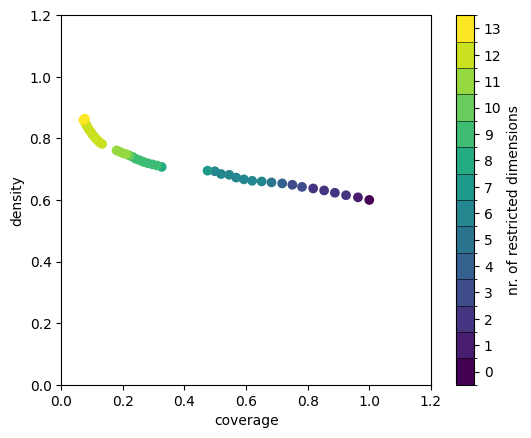

In [8]:
# initialize PRIM with uncertainties and unfavourable outcomes
prim_alg_unfavourable = prim.Prim(x_uncertainties, y_unfavourable, threshold = 0.8)

# search for box
box_unfavourable = prim_alg_unfavourable.find_box()

# show trade-offs between coverage and density plot
box_unfavourable.show_tradeoff()
plt.show()


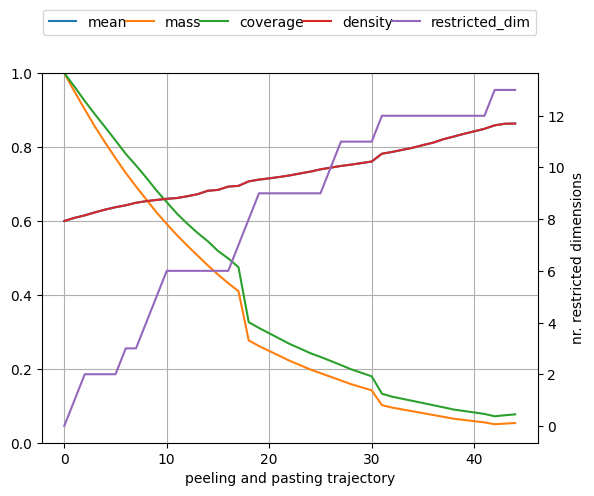

In [9]:
# show the progress plot for unfavourable outcomes
box_unfavourable.show_ppt()
plt.show()

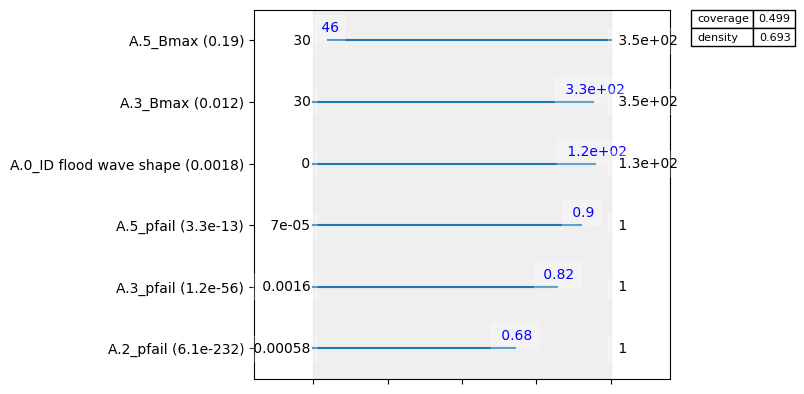

In [23]:
point = 16 # Selecting the point to inspect based on the trade-off plot
box_unfavourable.inspect(point, style='graph') # Inspect the selected box using a graphical representation
plt.show()

The density of the full sample is already relatively high and increases only slowly. Point 18 was selected for inspection as it represents a point just before a significant jump in the restricted dimensions. However, other points could also have been chosen for analysis.

In the graphical representation of the box, several key uncertainties become clear:
- pfail for A.2, A.3, and A.4: This type of uncertainty is seemingly a driver for bad outcomes. 
- A.3_pfail, A.3_Brate and A.3_Bmax: These parameters suggest that A.3 may be an area where a significant number of deaths or damages could occur.
- Flood wave shape: This uncertainty also plays a role, but is currently treated as a range. Ideally, it should be treated as a categorical variable, where individual entries are excluded rather than that is represented as a continuous range.

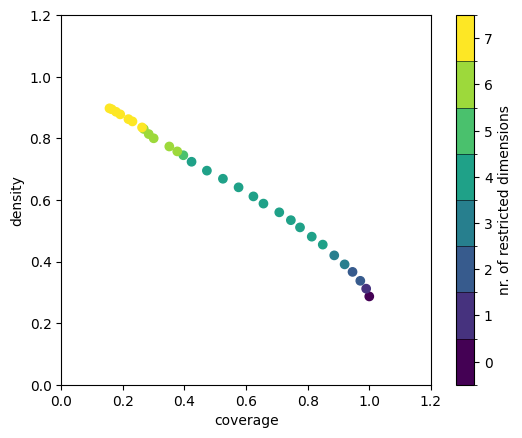

In [11]:
# initialize PRIM with levers and favourable outcomes
prim_alg_favourable = prim.Prim(x_levers, y_favourable, threshold = 0.8)

# search for box
box_favourable= prim_alg_favourable.find_box()

# show trade-offs between coverage and density plot
box_favourable.show_tradeoff()
plt.show()


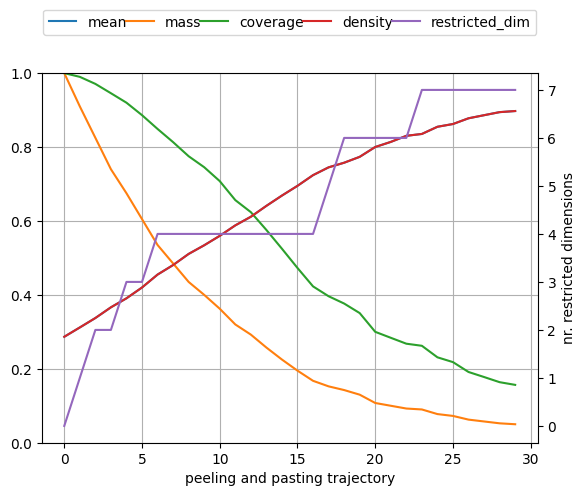

In [12]:
# show the progress plot for favourable outcomes
box_favourable.show_ppt()
plt.show()

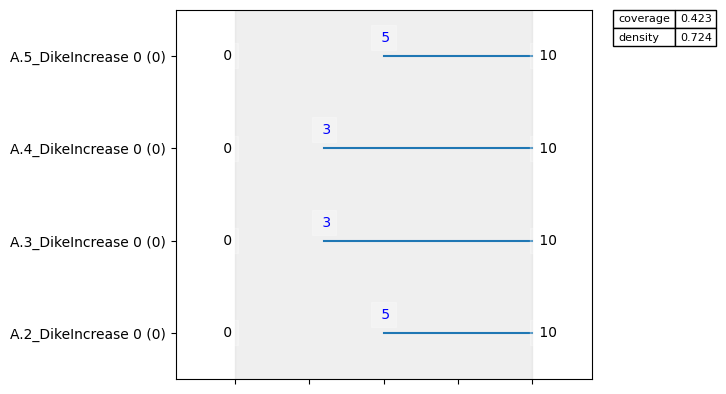

In [13]:
point = 16 # Selecting the point to inspect based on the trade-off plot
box_favourable.inspect(point, style='graph') # Inspect the selected box using a graphical representation
plt.show()

The density of the full sample is lower in this PRIM analysis and increases steadily. Point 17 was selected for inspection as it represents a point just before a notable jump in the restricted dimensions. Additionally, it marks the end of a long trajectory involving the use of four restricted dimensions.

In the graphical representation of the box, it becomes clear that DikeIncrease 0 at locations A.2, A.3, A.4 and A.5 are the most effective levers for reducing casualties and damages. Dike increases appear to be the most effective strategy to minimize casualties and damages.

### DS

In this section, the Dimensional Stacking (DS) is applied to analyze the results of the same run that was analyzed with PRIM. The use of DS here serves as an extension of PRIM and aims to answer the same two key questions. The same cases of interest are used against the uncertainty and lever space respectively.

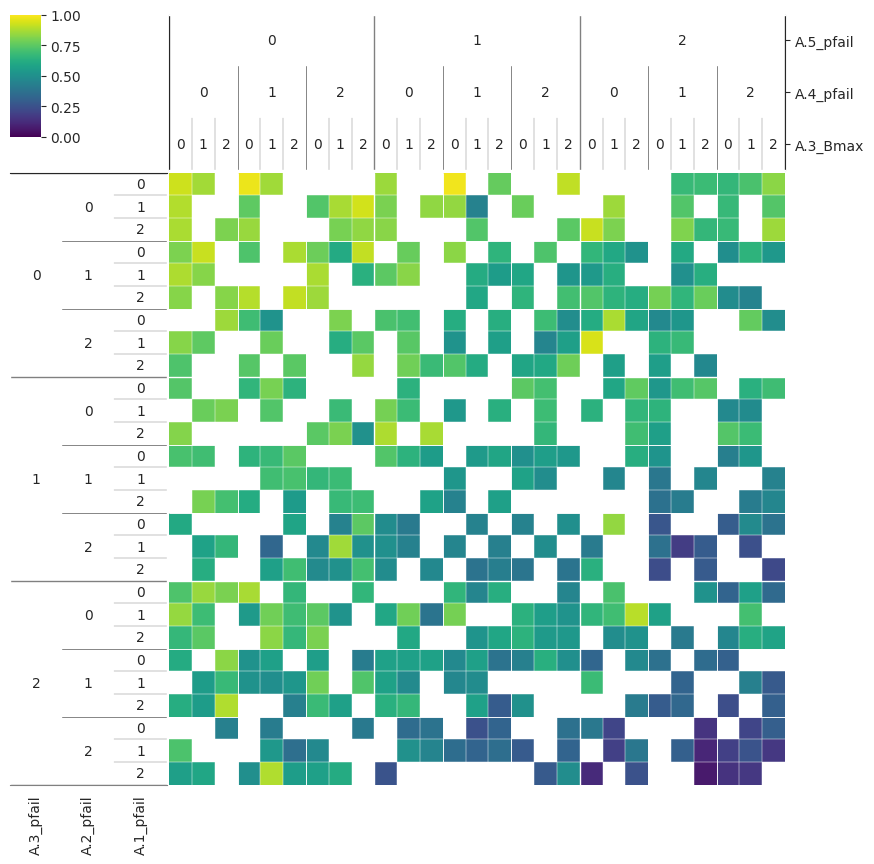

In [14]:
dimensional_stacking.create_pivot_plot(x_uncertainties, y_unfavourable.to_numpy())
plt.show()

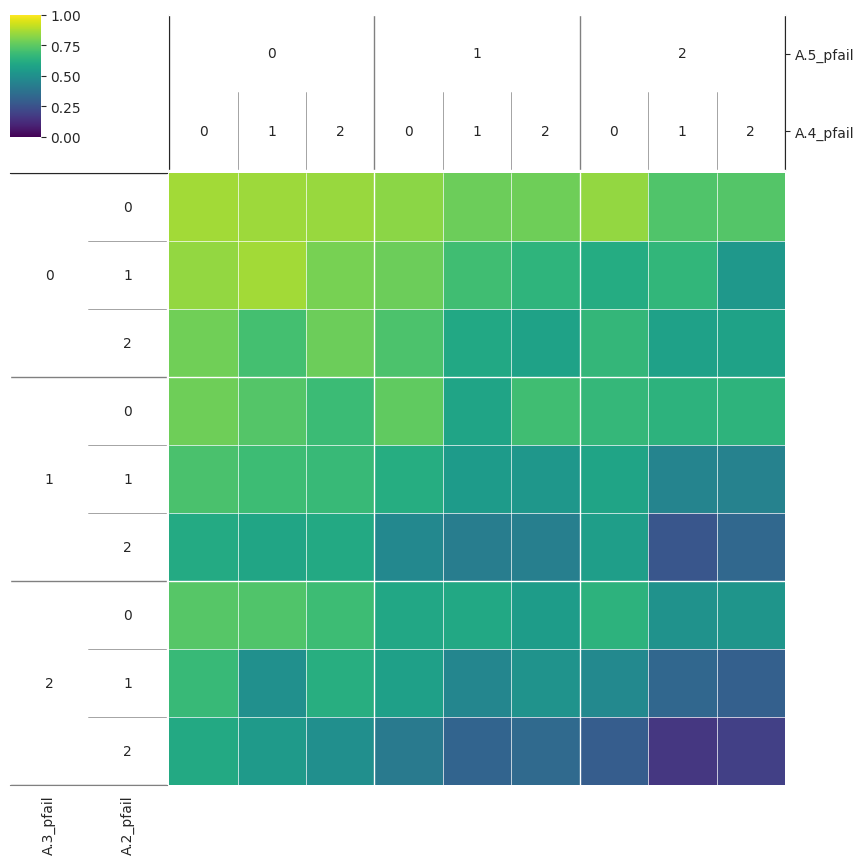

In [15]:
dimensional_stacking.create_pivot_plot(x_uncertainties, y_unfavourable.to_numpy(), 2)
plt.show()

The DS pivot plot reveals that certain pfail values in areas A.2, A.3, A.4, and A.5 are associated with unfavorable outcomes. Specifically, A.3_pfail and A.5_pfail are the most influential uncertainties leading to high numbers of deaths and damages.

Additionally, B_max in A.3 and A.5 contributes to unfavorable outcomes, though to a lesser extent.

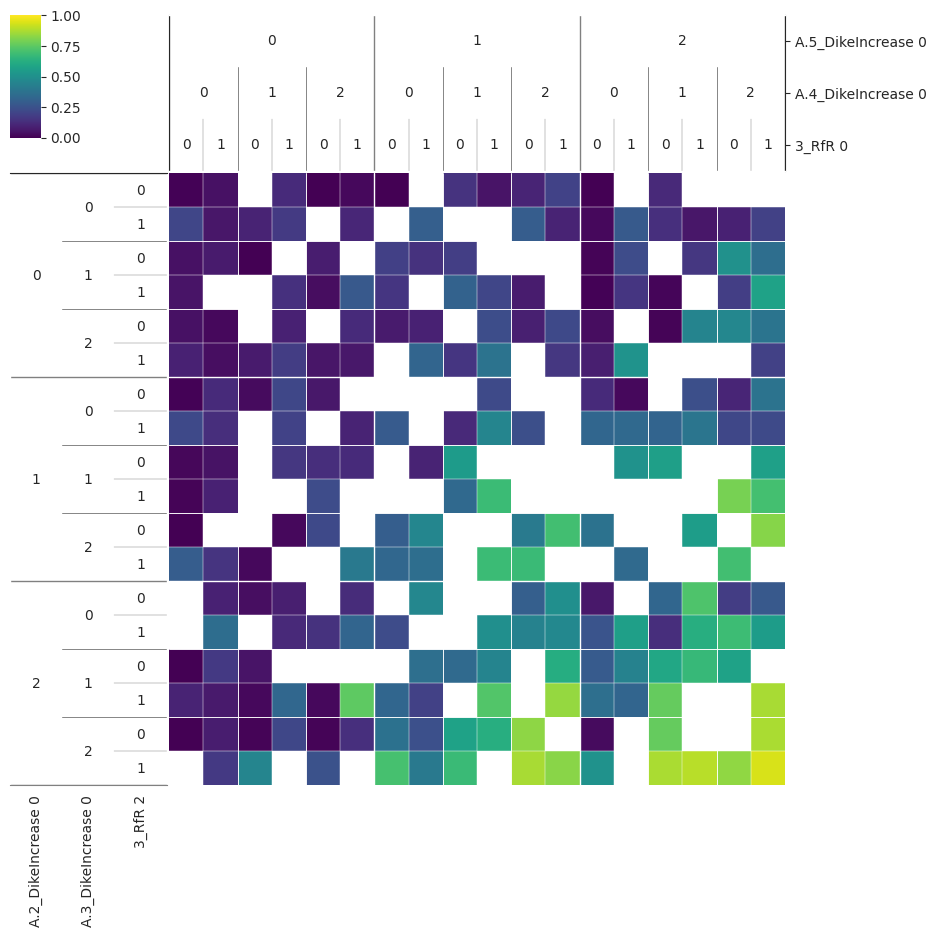

In [16]:
#y_deaths = data_lhs_outcomes['Expected Number of Deaths'].to_numpy() 
#y_discretized = pd.cut(y_deaths, bins=5, labels=False)  # Equal-width bins
#y_discretized = y_discretized.to_numpy()

dimensional_stacking.create_pivot_plot(x_levers, y_favourable.to_numpy())
plt.show()

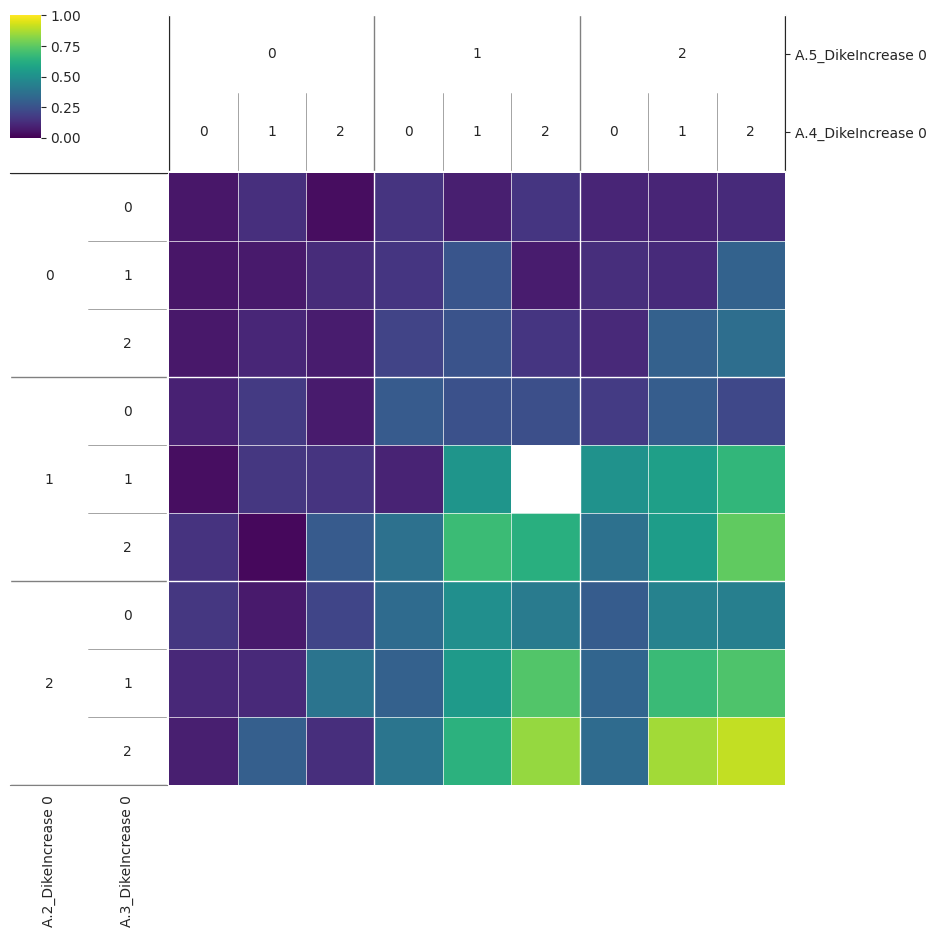

In [17]:
dimensional_stacking.create_pivot_plot(x_levers, y_favourable.to_numpy(), 2)
plt.show()

The DS pivot plot reveals that high DikeIncrease 0 in areas A.2, A.3, A.4, and A.5 are associated with favorable outcomes. Specifically, in A.2 and A.5, the dike increases are most influential in reducing the deaths and damages.

Additionally, the room for the river project in A.3 might also be effective in reducing deaths and damages.

### Sobol Indices
Sobol indices are applied in this part of the notebook on both the uncertainty and lever space. As Sobol sampling is really computationally expensive, only reference scenario and policy are used. The reference scenario has all its uncertainties at the average value and the ID flood wave shape = 4. The reference policy is the 'do-nothing policy' mentioned earlier. 

As our main concerns are the annual damages and deaths, these two outputs are investigated below.


In [18]:
# load Sobol data from the sobol_results folder
SOBOL_policies_experiments = pd.read_csv("sobol_results/SOBOL_policies_experiments_2025-06-18.csv")
SOBOL_policies_outcomes = pd.read_csv("sobol_results/SOBOL_policies_outcomes_2025-06-18.csv")

SOBOL_scenarios_experiments = pd.read_csv("sobol_results/SOBOL_scenarios_experiments_2025-06-18.csv")
SOBOL_scenarios_outcomes = pd.read_csv("sobol_results/SOBOL_scenarios_outcomes_2025-06-18.csv")

print(SOBOL_policies_experiments.shape)

(262144, 53)


In [19]:
problem_scenarios = get_SALib_problem(dike_model.uncertainties)
problem_levers = get_SALib_problem(dike_model.levers)

y_scenarios_deaths = SOBOL_scenarios_outcomes['Expected Number of Deaths'].to_numpy()
y_levers_deaths = SOBOL_policies_outcomes['Expected Number of Deaths'].to_numpy()

Si_uncertainties_deaths = sobol.analyze(problem_scenarios, y_scenarios_deaths, calc_second_order=True, print_to_console=True)
Si_levers_deaths = sobol.analyze(problem_levers, y_levers_deaths, calc_second_order=True, print_to_console=True)

                               ST   ST_conf
A.0_ID flood wave shape  0.009415  0.001016
A.1_Bmax                 0.042815  0.006936
A.1_Brate                0.000263  0.000070
A.1_pfail                0.253409  0.013109
A.2_Bmax                 0.002901  0.001495
A.2_Brate                0.000058  0.000028
A.2_pfail                0.039892  0.006255
A.3_Bmax                 0.000271  0.000114
A.3_Brate                0.000018  0.000012
A.3_pfail                0.823595  0.033588
A.4_Bmax                 0.000020  0.000012
A.4_Brate                0.000003  0.000002
A.4_pfail                0.002547  0.000534
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.024830  0.002134
discount rate 0          0.000000  0.000000
discount rate 1          0.000000  0.000000
discount rate 2          0.000000  0.000000
                               S1   S1_conf
A.0_ID flood wave shape  0.003241  0.004342
A.1_Bmax                 0.00316

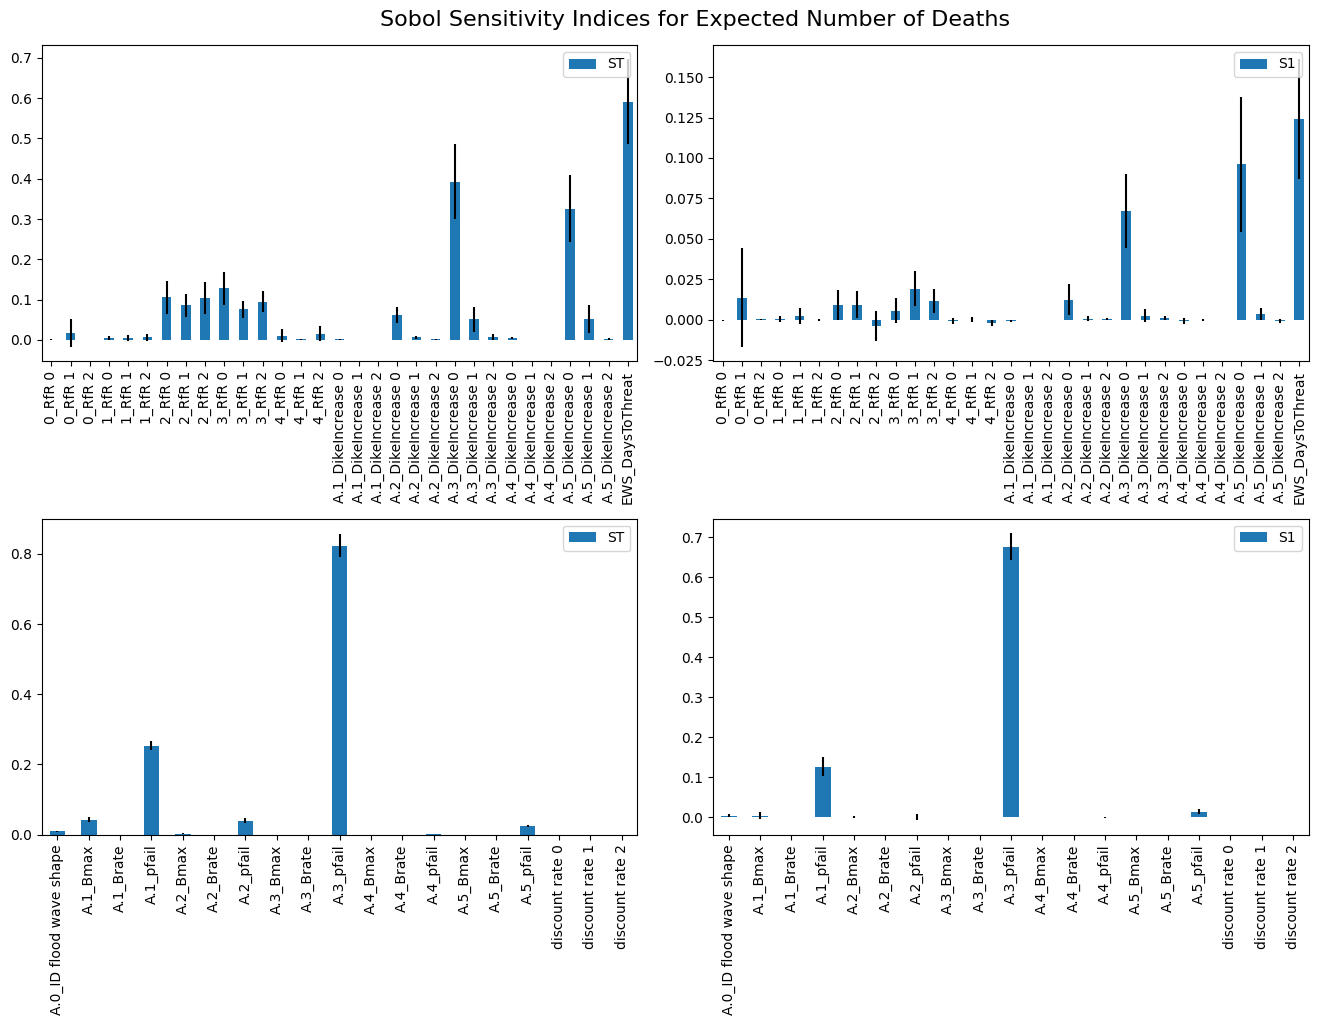

In [32]:
fig, axes = plt.subplots(2, 3)  # Create a 2x3 grid of subplots
fig.set_size_inches(20, 10)  # Adjust the figure size

# Plot Si_levers on the first row
Si_levers_deaths.plot(ax=axes[0, :])  # Use all three subplots in the first row
fig.delaxes(axes[0, 2])  # Remove the third subplot (S2) in the first row

# Plot Si_uncertainties on the second row
Si_uncertainties_deaths.plot(ax=axes[1, :])  # Use all three subplots in the second row
fig.delaxes(axes[1, 2])  # Remove the third subplot (S2) in the second row

# Adjust layout to remove empty spaces
fig.tight_layout()
# Give title to the figure
fig.suptitle('Sobol Sensitivity Indices for Expected Number of Deaths', fontsize=16, y=1.02, x=0.35)

plt.show()

From the figure above, it becomes apparant that EWS_DaysToThreat is the most important lever to influence and likely lower the expected number of deaths. Furthermore, A.3_DikeIncrease 0 and A.5_DikeIncrease seem promising. 

On the scenario side, the uncertainty of A.3_pfail has the most impact on the number of deaths. A.1_pfail also has a lesser, but still considerable impact.

In [21]:
problem_scenarios = get_SALib_problem(dike_model.uncertainties)
problem_levers = get_SALib_problem(dike_model.levers)

y_scenarios_damage = SOBOL_scenarios_outcomes['Expected Annual Damage'].to_numpy()
y_levers_damage = SOBOL_policies_outcomes['Expected Annual Damage'].to_numpy()

Si_uncertainties_damage = sobol.analyze(problem_scenarios, y_scenarios_damage, calc_second_order=True, print_to_console=True)
Si_levers_damage = sobol.analyze(problem_levers, y_levers_damage, calc_second_order=True, print_to_console=True)

                               ST   ST_conf
A.0_ID flood wave shape  0.006210  0.000623
A.1_Bmax                 0.019840  0.003070
A.1_Brate                0.000127  0.000035
A.1_pfail                0.666659  0.030693
A.2_Bmax                 0.001474  0.000617
A.2_Brate                0.000041  0.000017
A.2_pfail                0.029937  0.002526
A.3_Bmax                 0.000384  0.000179
A.3_Brate                0.000025  0.000017
A.3_pfail                0.269823  0.013326
A.4_Bmax                 0.000023  0.000012
A.4_Brate                0.000003  0.000003
A.4_pfail                0.003162  0.000576
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.034224  0.003657
discount rate 0          0.026259  0.001469
discount rate 1          0.026141  0.001449
discount rate 2          0.026106  0.001523
                               S1   S1_conf
A.0_ID flood wave shape  0.003385  0.003211
A.1_Bmax                 0.00222

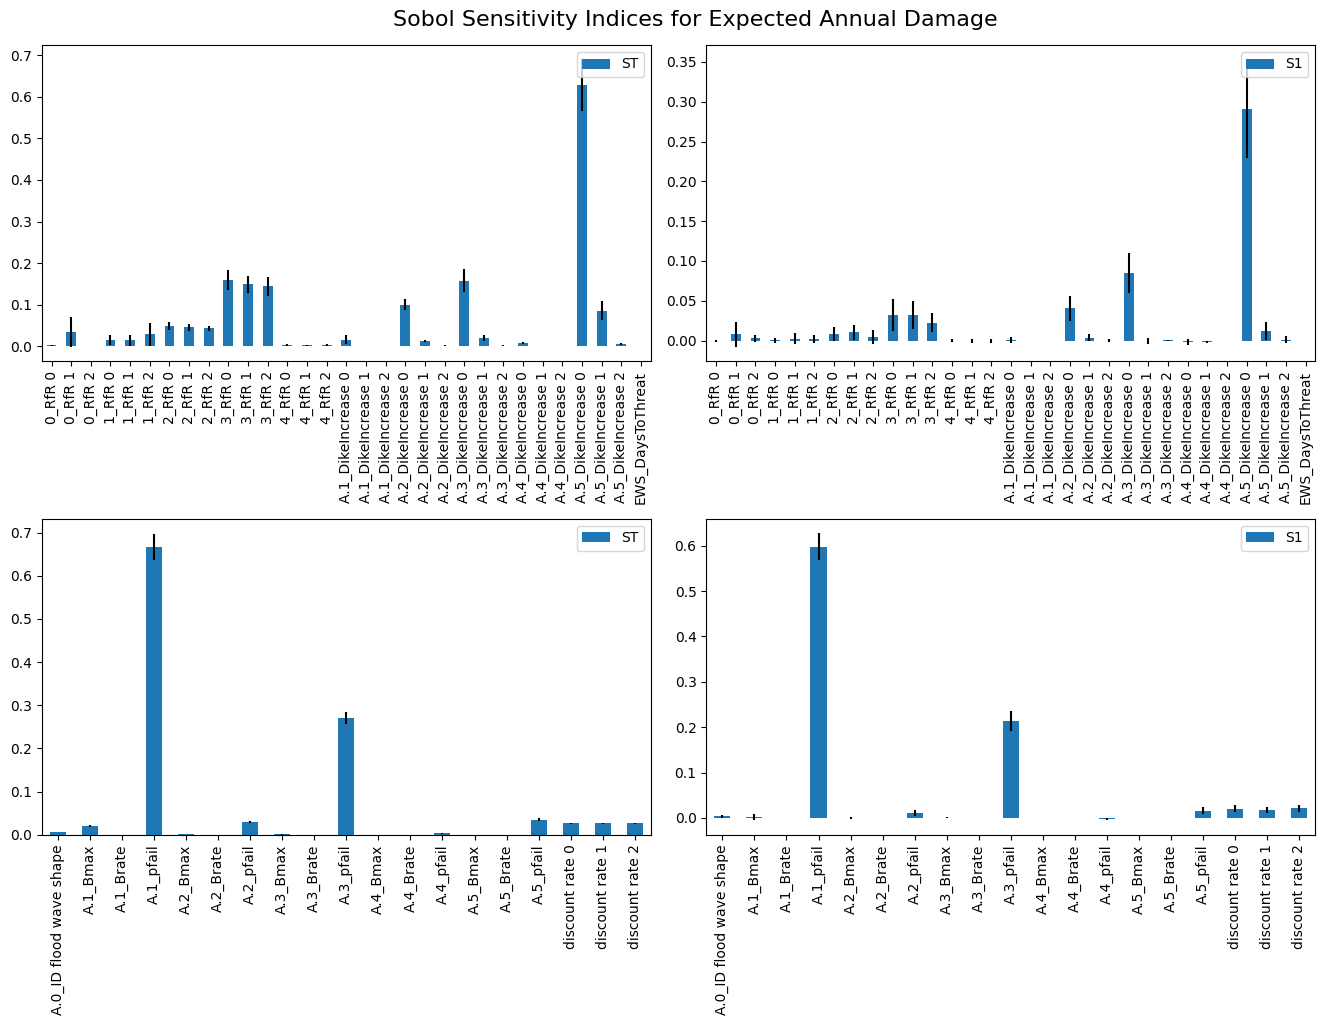

In [33]:
fig, axes = plt.subplots(2, 3)  # Create a 2x3 grid of subplots
fig.set_size_inches(20, 10)  # Adjust the figure size

# Plot Si_levers on the first row
Si_levers_damage.plot(ax=axes[0, :])  # Use all three subplots in the first row
fig.delaxes(axes[0, 2])  # Remove the third subplot in the first row

# Plot Si_uncertainties on the second row
Si_uncertainties_damage.plot(ax=axes[1, :])  # Use all three subplots in the second row
fig.delaxes(axes[1, 2])  # Remove the third subplot in the second row

# Adjust layout to remove empty spaces
fig.tight_layout()
# Give title to the figure

fig.suptitle('Sobol Sensitivity Indices for Expected Annual Damage', fontsize=16, y=1.02, x=0.35)


plt.show()

From the figure above, it becomes apparant that A.5_DikeIncrease is the most important lever to influence the expected amount of damage. Furthermore, A.3_DikeIncrease 0 and 3_RfR also have noticable effects. 

On the scenario side, the uncertainty of A.1_pfail has the most impact on the expected damage. A.3_pfail also has a considerable impact.

## Directed search